### 코랩 라이브러리 다운

In [2]:
# !pip install "numpy<2.0" --force-reinstall
! pip install git+https://github.com/yura52/rtdl.git
! pip install optuna
# import os; os.kill(os.getpid(), 9)  # 🔁 런타임 재시작

  Cloning https://github.com/yura52/rtdl.git to /tmp/pip-req-build-m9rz3ezu
  Running command git clone --filter=blob:none --quiet https://github.com/yura52/rtdl.git /tmp/pip-req-build-m9rz3ezu
  Resolved https://github.com/yura52/rtdl.git to commit bdc2fe52e0c28d0d15a3cf7d99ef94a452f23253
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 107.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━

### 라이브러리 호출

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import pickle
from pytorch_tabnet.tab_model import TabNetRegressor

### 모델 학습

In [12]:
with open("./split_data/VIF_split_data_3way.pkl", "rb") as f:
    X_train, X_valid, X_test, y_train, y_valid, y_test = pickle.load(f)

In [ ]:
# 2차원으로 저장되어 있음
print(y_train.shape)

(298092, 1)


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.ensemble import HistGradientBoostingRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import ElasticNet
import warnings
import numpy as np
warnings.filterwarnings("ignore")

models = {
    "CatBoost": (
        CatBoostRegressor(verbose=0, random_state=42),
        {
            "depth": [4, 6, 8, 10],
            "learning_rate": [0.01, 0.05, 0.1],
            "iterations": [200, 400, 600], # 반복 횟수
            "l2_leaf_reg": [3, 5, 7] # 정규화 계수 
        }
    ),
    "LightGBM": (
        LGBMRegressor(random_state=42),
        {
            "num_leaves": [15, 31, 63],
            "max_depth": [-1, 5, 10, 20],
            "learning_rate": [0.01, 0.05, 0.1],
            "n_estimators": [100, 300, 500], # 트리 개수
            "min_child_samples": [5, 10, 20] # 한 잎 당 최소 샘플 개수 
        }
    ),
    "XGBoost": (
        XGBRegressor(random_state=42, verbosity=0),
        {
            "max_depth": [3, 5, 7, 10],
            "learning_rate": [0.01, 0.1, 0.2],
            "n_estimators": [100, 300], # 트리 수
            "subsample": [0.6, 0.8, 1.0] # 사용할 샘플 비율 
        }
    ),
    "HistGBR": (
        HistGradientBoostingRegressor(random_state=42),
        {
            "max_iter": [100, 300, 500], # 최대 반복 횟수
            "learning_rate": [0.01, 0.05, 0.1],
            "max_depth": [None, 10, 20, 30],
            "min_samples_leaf": [20, 50, 100],
            "l2_regularization": [0.0, 0.1, 1.0] # l2 정규화 계수 
        }
    ),
    "ElasticNet": (
    ElasticNet(random_state=42, max_iter=10000),
    {
        "alpha": [0.01, 0.1, 1.0, 10.0], # 전체 규제 강도
        "l1_ratio": [0.1, 0.5, 0.9], # l1, l2 규제 비율 
        "tol": [1e-4, 1e-3, 1e-2] # 수렴 허용 오차 
    }
)
}

results = {}
total_models = len(models)

for i, (name, (model, param_grid)) in enumerate(models.items()):
    print(f"\n🔍 [{i+1}/{total_models}] Random Search for {name}...")

    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid, # 탐색 공간
        n_iter=10, # 조합 수
        scoring="neg_mean_squared_error",
        cv=3, # 교차 검증 횟수 
        n_jobs=-1,
        verbose=1,
        random_state=42
    )

    search.fit(X_train, y_train.ravel()) # 2차원->1차원

    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test)

    # 평가 지표 계산
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results[name] = {
        "best_params": search.best_params_,
        "test_rmse": rmse,
        "test_r2": r2
    }

    # 개별 결과 즉시 출력
    print(f"✅ {name} 학습 완료")
    print(f"📌 최적 파라미터: {search.best_params_}")
    print(f"📊 테스트 RMSE: {rmse:.6f}")
    print(f"📈 테스트 R²: {r2:.4f}")

# 전체 결과 요약
print("\n✅ 최종 결과 요약:")
for model_name, res in results.items():
    print(f"📌 {model_name} | RMSE: {res['test_rmse']:.6f} | R²: {res['test_r2']:.4f} | Best Params: {res['best_params']}")


🔍 [1/5] Random Search for CatBoost...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
✅ CatBoost 학습 완료
📌 최적 파라미터: {'learning_rate': 0.05, 'l2_leaf_reg': 5, 'iterations': 400, 'depth': 8}
📊 테스트 RMSE: 0.009858
📈 테스트 R²: 0.6285

🔍 [2/5] Random Search for LightGBM...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.067924 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 373
[LightGBM] [Info] Number of data points in the train set: 298092, number of used features: 60
[LightGBM] [Info] Start training from score 0.005130
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

모델 추가

In [ ]:
import numpy as np
import time
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import warnings
from tqdm import tqdm

warnings.filterwarnings("ignore")

# ⏱ 시간 측정 시작
start = time.time()

# 1. 모델 및 파라미터 후보 정의
rf_model = RandomForestRegressor(random_state=42)
rf_param_grid = {
    "n_estimators": [100, 200, 300], # 트리 개수
    "max_depth": [10, 15, 20], 
    "min_samples_split": [2, 4, 6], # 분기기준 최소 샘플 수 
    "min_samples_leaf": [1, 2] # 리프 노드의 최소 샘플 수
}

# 2. 랜덤 서치
search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=rf_param_grid,
    n_iter=10,
    scoring="neg_mean_squared_error",
    cv=3,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

print("🔍 Random Forest 하이퍼파라미터 탐색 중...")
search.fit(X_train, y_train.ravel())

# 3. 예측 및 평가
best_rf = search.best_estimator_
y_pred = best_rf.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# 4. 결과 출력
print(f"✅ RandomForest 학습 완료")
print(f"📌 최적 파라미터: {search.best_params_}")
print(f"📊 테스트 RMSE: {rmse:.6f}")
print(f"📈 테스트 R²: {r2:.4f}")

# ⏱ 시간 측정 종료
print(f"⏱ 실행 시간: {(time.time() - start):.2f}초")

🔍 Random Forest 하이퍼파라미터 탐색 중...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
✅ RandomForest 학습 완료
📌 최적 파라미터: {'n_estimators': 300, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_depth': 10}
📊 테스트 RMSE: 0.010052
📈 테스트 R²: 0.6137
⏱ 실행 시간: 9421.37초


In [12]:
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# 1. Min-Max 정규화 기준값
y_min = 216.0
y_max = 165300000.0

# 2. 최적 하이퍼파라미터 적용 모델 정의
models = {
    "CatBoost": CatBoostRegressor(
        learning_rate=0.05, l2_leaf_reg=5, iterations=400, depth=8,
        verbose=0, random_state=42
    ),
    "LightGBM": LGBMRegressor(
        num_leaves=63, n_estimators=300, min_child_samples=20,
        max_depth=5, learning_rate=0.1, random_state=42
    ),
    "XGBoost": XGBRegressor(
        subsample=0.8, n_estimators=300, max_depth=5,
        learning_rate=0.1, random_state=42, verbosity=0
    ),
    "HistGBR": HistGradientBoostingRegressor(
        min_samples_leaf=50, max_iter=500, max_depth=10,
        learning_rate=0.1, l2_regularization=0.1, random_state=42
    ),
    "RandomForestRegressor": RandomForestRegressor(
        n_estimators=300, min_samples_split=6, min_samples_leaf=2,
        max_depth=10, random_state=42
    )
}

# 3. 결과 저장용 딕셔너리
results = {}

# 4. 모델 학습 → 예측 → 역정규화 → 성능 평가
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    # 역정규화
    preds_inverse = preds * (y_max - y_min) + y_min
    y_test_inverse = y_test * (y_max - y_min) + y_min

    # 성능 평가
    mse = mean_squared_error(y_test_inverse, preds_inverse)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_inverse, preds_inverse)

    results[name] = {
        "RMSE": round(rmse, 2),
        "R²": round(r2, 4)
    }

# 5. 결과 출력
print("📊 역정규화 기준 모델 성능 비교:")
for name, res in results.items():
    print(f"✅ {name:<8} | RMSE: {res['RMSE']:,} | R²: {res['R²']}")

c:\Users\jeongbin\Projects\LandValue_project\venv\lib\site-packages\lightgbm\basic.py:374: UserWarning: Converting column-vector to 1d array
  _log_warning("Converting column-vector to 1d array")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035791 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 373
[LightGBM] [Info] Number of data points in the train set: 298092, number of used features: 60
[LightGBM] [Info] Start training from score 0.005130
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

c:\Users\jeongbin\Projects\LandValue_project\venv\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\jeongbin\Projects\LandValue_project\venv\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


📊 역정규화 기준 모델 성능 비교:
✅ CatBoost | RMSE: 1,629,459.9 | R²: 0.6285
✅ LightGBM | RMSE: 1,640,651.31 | R²: 0.6233
✅ XGBoost  | RMSE: 1,638,777.5 | R²: 0.6242
✅ HistGBR  | RMSE: 1,644,349.43 | R²: 0.6216
✅ RandomForestRegressor | RMSE: 1,661,596.08 | R²: 0.6137


In [ ]:
import joblib

# 머신러닝 모델만 추출 (딥러닝 모델 제외)
ml_models = {k: v for k, v in models.items() if k not in ["TabNet", "FTTransformer"]}

# 저장
joblib.dump(ml_models, "./model/VIF_ML_models.pkl")


['VIF_ML_models.pkl']

In [10]:
import joblib
from sklearn.metrics import mean_squared_error, r2_score
# 불러오기
loaded_models = joblib.load("./model/VIF_ML_models.pkl")

y_min = 216.0
y_max = 165300000.0
results={}
# 불러온 모델로 성능 평가
for name, model in loaded_models.items():
    preds = model.predict(X_test)

    # 역정규화
    preds_inverse = preds * (y_max - y_min) + y_min
    y_test_inverse = y_test * (y_max - y_min) + y_min

    # 성능 평가
    mse = mean_squared_error(y_test_inverse, preds_inverse)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_inverse, preds_inverse)

    results[name] = {
        "RMSE": round(rmse, 2),
        "R²": round(r2, 4)
    }

# 결과 출력
print("📊 역정규화 기준 모델 성능 비교:")
for name, res in results.items():
    print(f"✅ {name:<8} | RMSE: {res['RMSE']:,} | R²: {res['R²']}")


📊 역정규화 기준 모델 성능 비교:
✅ CatBoost | RMSE: 1,629,459.9 | R²: 0.6285
✅ LightGBM | RMSE: 1,640,651.31 | R²: 0.6233
✅ XGBoost  | RMSE: 1,638,777.5 | R²: 0.6242
✅ HistGBR  | RMSE: 1,644,349.43 | R²: 0.6216
✅ RandomForestRegressor | RMSE: 1,661,596.08 | R²: 0.6137


### tabnet

In [ ]:
import optuna
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error

def objective(trial):
    model = TabNetRegressor(
        n_d=trial.suggest_categorical("n_d", [8, 16, 24]), # 디코더 차원 수
        n_a=trial.suggest_categorical("n_a", [8, 16, 24]), #  어텐션 피처 차원 수
        n_steps=trial.suggest_categorical("n_steps", [3, 5]), # 결정 반복 횟수-> 하나의 입력을 여러번 학습
        gamma=trial.suggest_float("gamma", 1.2, 1.5, step=0.1),  # 이전 정보를 얼마나 활용할지 결정
        lambda_sparse=1e-3,  # 희소성 정규화 강도 고정 L1과 유사한 역할
        optimizer_params=dict(lr=0.02),  
        verbose=0,
        seed=42
    )

    model.fit(
        X_train=X_train.values,
        y_train=y_train,
        eval_set=[(X_valid.values, y_valid)],
        eval_metric=['rmse'],
        max_epochs=100,
        patience=10, # 조기종료 조건
        batch_size=1024,
        virtual_batch_size=128
    )

    preds = model.predict(X_valid.values).squeeze()
    mse = mean_squared_error(y_valid, preds)
    rmse = np.sqrt(mse)
    return rmse

study = optuna.create_study(direction="minimize") #rmse 최소화 방향
study.optimize(objective, n_trials=5)  # 가볍게 5회만 탐색

print("✅ Best RMSE:", study.best_value)
print("✅ Best Params:", study.best_params)

[I 2025-05-24 03:10:31,847] A new study created in memory with name: no-name-54bc7eae-5bc9-477a-a696-ee7fbeecbd08



Early stopping occurred at epoch 35 with best_epoch = 25 and best_val_0_rmse = 0.01172


[I 2025-05-24 03:46:03,583] Trial 0 finished with value: 0.011720491904511559 and parameters: {'n_d': 8, 'n_a': 16, 'n_steps': 5, 'gamma': 1.4}. Best is trial 0 with value: 0.011720491904511559.



Early stopping occurred at epoch 29 with best_epoch = 19 and best_val_0_rmse = 0.01103


[I 2025-05-24 04:06:45,681] Trial 1 finished with value: 0.011033960523769933 and parameters: {'n_d': 16, 'n_a': 16, 'n_steps': 5, 'gamma': 1.5}. Best is trial 1 with value: 0.011033960523769933.



Early stopping occurred at epoch 27 with best_epoch = 17 and best_val_0_rmse = 0.01


[I 2025-05-24 04:26:03,008] Trial 2 finished with value: 0.009997092288991523 and parameters: {'n_d': 16, 'n_a': 24, 'n_steps': 5, 'gamma': 1.2}. Best is trial 2 with value: 0.009997092288991523.



Early stopping occurred at epoch 42 with best_epoch = 32 and best_val_0_rmse = 0.01094


[I 2025-05-24 04:54:21,860] Trial 3 finished with value: 0.010935643849649249 and parameters: {'n_d': 8, 'n_a': 24, 'n_steps': 5, 'gamma': 1.5}. Best is trial 2 with value: 0.009997092288991523.



Early stopping occurred at epoch 27 with best_epoch = 17 and best_val_0_rmse = 0.01


[I 2025-05-24 05:13:39,259] Trial 4 finished with value: 0.009997092288991523 and parameters: {'n_d': 16, 'n_a': 24, 'n_steps': 5, 'gamma': 1.2}. Best is trial 2 with value: 0.009997092288991523.


✅ Best RMSE: 0.009997092288991523
✅ Best Params: {'n_d': 16, 'n_a': 24, 'n_steps': 5, 'gamma': 1.2}


In [ ]:
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.metrics import mean_squared_error, r2_score
import optuna
import torch
from tqdm import tqdm
import numpy as np

# tqdm 진행률 바
NUM_TRIALS = 5
pbar = tqdm(total=NUM_TRIALS, desc="🔍 TabNet Tuning Progress")

def objective_hyper(trial):
    model = TabNetRegressor(
        n_d=16,  # 고정
        n_a=24,   # 고정
        n_steps=5,  # 고정
        gamma=1.2,  # 고정
        lambda_sparse=trial.suggest_float("lambda_sparse", 1e-5, 1e-2, log=True), #l1 정규화 계수
        optimizer_params=dict(
            lr=trial.suggest_float("lr", 1e-4, 1e-1, log=True)
        ),
        verbose=0,
        seed=42,
        device_name="cuda" if torch.cuda.is_available() else "cpu"
    )

    model.fit(
        X_train=X_train.values,
        y_train=y_train,
        eval_set=[(X_valid.values, y_valid)],
        eval_metric=['rmse'],
        max_epochs=80,
        patience=7,# 조기종료 조건 7로 변경 
        batch_size=trial.suggest_categorical("batch_size", [1024, 2048]),
        virtual_batch_size=trial.suggest_categorical("virtual_batch_size", [64, 128,256])
        # 배치 정규화 단위
    )

    preds = model.predict(X_valid.values).squeeze()  
    mse = mean_squared_error(y_valid, preds)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_valid, preds)

    trial.set_user_attr("r2", r2) # r2 성능도 기록
    pbar.update(1)
    return rmse

# Optuna 튜닝 실행
study_hyper = optuna.create_study(direction="minimize")
study_hyper.optimize(objective_hyper, n_trials=NUM_TRIALS)

# 결과 출력
print("📌 Best RMSE:", study_hyper.best_value)
print("📌 Best Hyperparams:", study_hyper.best_params)

best_trial = study_hyper.best_trial
print("📈 Best R²:", best_trial.user_attrs.get("r2", "N/A"))


🔍 TabNet Tuning Progress:   0%|          | 0/5 [00:27<?, ?it/s]
[I 2025-05-24 15:17:51,488] A new study created in memory with name: no-name-a9d1b856-aa16-42dd-9ab9-5023b8f7b499



Early stopping occurred at epoch 25 with best_epoch = 18 and best_val_0_rmse = 0.01053


[I 2025-05-24 15:40:47,205] Trial 0 finished with value: 0.010531043679974672 and parameters: {'lambda_sparse': 0.000153392735123354, 'lr': 0.017571982958261966, 'batch_size': 2048, 'virtual_batch_size': 64}. Best is trial 0 with value: 0.010531043679974672.



Early stopping occurred at epoch 34 with best_epoch = 27 and best_val_0_rmse = 0.01151


[I 2025-05-24 16:02:59,438] Trial 1 finished with value: 0.011513525559008283 and parameters: {'lambda_sparse': 0.009435451538252206, 'lr': 0.02531309831919276, 'batch_size': 2048, 'virtual_batch_size': 128}. Best is trial 0 with value: 0.010531043679974672.



Early stopping occurred at epoch 31 with best_epoch = 24 and best_val_0_rmse = 0.00933


[I 2025-05-24 16:27:01,351] Trial 2 finished with value: 0.009325077225435975 and parameters: {'lambda_sparse': 7.171383915619376e-05, 'lr': 0.0598204398273156, 'batch_size': 1024, 'virtual_batch_size': 256}. Best is trial 2 with value: 0.009325077225435975.



Early stopping occurred at epoch 26 with best_epoch = 19 and best_val_0_rmse = 0.01026


[I 2025-05-24 16:50:49,052] Trial 3 finished with value: 0.01026055281527475 and parameters: {'lambda_sparse': 4.2458412547034734e-05, 'lr': 0.00587107133120513, 'batch_size': 1024, 'virtual_batch_size': 128}. Best is trial 2 with value: 0.009325077225435975.


Stop training because you reached max_epochs = 80 with best_epoch = 76 and best_val_0_rmse = 0.00938


[I 2025-05-24 17:47:39,924] Trial 4 finished with value: 0.009381769619373271 and parameters: {'lambda_sparse': 1.0228033684425918e-05, 'lr': 0.0011984383873678893, 'batch_size': 1024, 'virtual_batch_size': 128}. Best is trial 2 with value: 0.009325077225435975.


📌 Best RMSE: 0.009325077225435975
📌 Best Hyperparams: {'lambda_sparse': 7.171383915619376e-05, 'lr': 0.0598204398273156, 'batch_size': 1024, 'virtual_batch_size': 256}
📈 Best R²: 0.6262643029044614


In [ ]:
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.metrics import mean_squared_error, r2_score
import torch
import numpy as np
import os
# 1. 최적 하이퍼파라미터
best_params = {
    'lambda_sparse': 7.171383915619376e-05,
    'lr': 0.0598204398273156,
    'batch_size': 1024,
    'virtual_batch_size': 256
}

# 2. TabNet 모델 생성
model = TabNetRegressor(
    n_d=16,  # 고정
    n_a=24,   # 고정
    n_steps=5,  # 고정
    gamma=1.2,  # 고정
    lambda_sparse=best_params['lambda_sparse'],
    optimizer_params=dict(lr=best_params['lr']),
    verbose=1,
    seed=42,
    device_name="cuda" if torch.cuda.is_available() else "cpu"
)

# 3. 학습
model.fit(
    X_train=X_train.values.astype(np.float32),  # float32로 변환해서 메모리 절약
    y_train=y_train,
    eval_set=[(X_valid.values.astype(np.float32), y_valid)],
    eval_metric=['rmse'],
    max_epochs=100,
    patience=10,
    batch_size=best_params['batch_size'],
    virtual_batch_size=best_params['virtual_batch_size']
)

# 4. 예측
preds = model.predict(X_test.values.astype(np.float32)).squeeze()

# 5. 역정규화
y_min = 216.0
y_max = 165300000.0

preds_inverse = preds * (y_max - y_min) + y_min
y_test_inverse = y_test * (y_max - y_min) + y_min

# 성능 평가
mse = mean_squared_error(y_test_inverse, preds_inverse)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_inverse, preds_inverse)

print(f"✅ 최종 RMSE: {rmse:.5f}")
print(f"✅ 최종 R²: {r2:.5f}")
# 저장 경로 지정
# 학습 완료된 model 객체 저장
model_save_path = "./best_VIF(X)_tabnet_model.zip"

epoch 0  | loss: 0.0367  | val_0_rmse: 0.01344 |  0:00:30s
epoch 1  | loss: 0.00021 | val_0_rmse: 0.01189 |  0:00:58s
epoch 2  | loss: 0.00018 | val_0_rmse: 0.01105 |  0:01:30s
epoch 3  | loss: 0.00017 | val_0_rmse: 0.01175 |  0:02:04s
epoch 4  | loss: 0.00015 | val_0_rmse: 0.00991 |  0:02:37s
epoch 5  | loss: 0.00015 | val_0_rmse: 0.01003 |  0:03:10s
epoch 6  | loss: 0.00014 | val_0_rmse: 0.0101  |  0:03:43s
epoch 7  | loss: 0.00014 | val_0_rmse: 0.01038 |  0:04:17s
epoch 8  | loss: 0.00014 | val_0_rmse: 0.00975 |  0:04:51s
epoch 9  | loss: 0.00013 | val_0_rmse: 0.01113 |  0:05:25s
epoch 10 | loss: 0.00017 | val_0_rmse: 0.01113 |  0:05:58s
epoch 11 | loss: 0.00015 | val_0_rmse: 0.01046 |  0:06:31s
epoch 12 | loss: 0.00014 | val_0_rmse: 0.00968 |  0:07:04s
epoch 13 | loss: 0.00013 | val_0_rmse: 0.00968 |  0:07:37s
epoch 14 | loss: 0.00012 | val_0_rmse: 0.01013 |  0:08:11s
epoch 15 | loss: 0.00012 | val_0_rmse: 0.00996 |  0:08:44s
epoch 16 | loss: 0.00012 | val_0_rmse: 0.00953 |  0:09:1

In [ ]:
# 학습 완료된 model 객체 저장
# model.save_model("./model/best_VIF(X)_tabnet_model.zip")


Successfully saved model at best_VIF(X)_tabnet_model.zip.zip


'best_VIF(X)_tabnet_model.zip.zip'

In [ ]:
loaded_model = TabNetRegressor()
loaded_model.load_model("./model/best_VIF(X)_tabnet_model.zip")

c:\Users\jeongbin\Projects\LandValue_project\venv\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [14]:
# 1. 기존 models 딕셔너리에 추가
models["TabNet"] = loaded_model

### ft-transformer 전처리

In [ ]:
df=pd.read_csv('../real_data/공시지가_전처리.csv')

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import torch
from torch.utils.data import TensorDataset

# 1. X, y 분리
X = df.drop(columns='내년_공시지가')
y = df['내년_공시지가']

# 2. 3-way split
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

# 3. 면적 MinMax 스케일링
scaler_area = MinMaxScaler()
X_train['면적'] = scaler_area.fit_transform(X_train[['면적']])
X_valid['면적'] = scaler_area.transform(X_valid[['면적']])
X_test['면적'] = scaler_area.transform(X_test[['면적']])

# 4. 타깃 MinMax 스케일링
scaler_target = MinMaxScaler()
y_train = scaler_target.fit_transform(y_train.values.reshape(-1, 1))
y_valid = scaler_target.transform(y_valid.values.reshape(-1, 1))
y_test = scaler_target.transform(y_test.values.reshape(-1, 1))

# 5. 명목형 변수 라벨 인코딩
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])
    X_valid[col] = le.transform(X_valid[col])
    X_test[col] = le.transform(X_test[col])
    label_encoders[col] = le


# 변수명에 존재하는 , 띄어쓰기 제거

X_train.columns = X_train.columns.str.replace(',', '_')
X_train.columns = X_train.columns.str.replace(' ', '_')
X_valid.columns = X_valid.columns.str.replace(',', '_')
X_valid.columns = X_valid.columns.str.replace(' ', '_')
X_test.columns = X_test.columns.str.replace(',', '_')
X_test.columns = X_test.columns.str.replace(' ', '_')


In [ ]:
from scipy.stats import chi2_contingency
from itertools import combinations

# ✅ Cramér’s V 계산 함수
# 라벨 인코딩된 범주형 변수 간의 상관성은 VIF로 판단할 수 없기 때문에 Cramér's V를 사용
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2, _, _, _ = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min(k - 1, r - 1))

# ✅ 라벨 인코딩된 범주형 변수들만 추출
categorical_cols = X_train.columns.tolist() 

# ✅ 변수쌍별 Cramér’s V 계산
high_corr_pairs = []
threshold = 0.7  # 제거 기준

for col1, col2 in combinations(categorical_cols, 2):
    v = cramers_v(X_train[col1], X_train[col2])
    if v > threshold:
        high_corr_pairs.append((col1, col2, v))

# ✅ 결과 출력
print("❗ Cramér’s V 0.7 이상인 변수쌍:")
for a, b, v in high_corr_pairs:
    print(f"{a} ↔ {b} : V = {v:.3f}")



❗ Cramér’s V 0.7 이상인 변수쌍:
지번구분 ↔ 면적 : V = 0.725
지목 ↔ 이용상황 : V = 0.744
면적 ↔ 임야구분 : V = 0.720
이용상황 ↔ 주위환경 : V = 0.784
이용상황 ↔ 임야구분 : V = 0.704
주위환경 ↔ 임야구분 : V = 0.703


In [ ]:
# 제거할 변수 목록
cols_to_drop = ["면적", "이용상황", "임야구분"]

# DataFrame에서 제거
X_train = X_train.drop(columns=cols_to_drop, errors="ignore")
X_valid = X_valid.drop(columns=cols_to_drop, errors="ignore")
X_test  = X_test.drop(columns=cols_to_drop, errors="ignore")


In [ ]:
# 변수별 {숫자: 실제값} 매핑 딕셔너리 생성
label_maps = {}

for col, le in label_encoders.items():
    label_maps[col] = {i: label for i, label in enumerate(le.classes_)}


In [ ]:
import pickle

with open("label_maps.pkl", "wb") as f:
    pickle.dump(label_maps, f)

print("✅ label_maps 저장 완료!")


✅ label_maps 저장 완료!


In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 298092 entries, 382498 to 236760
Data columns (total 12 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   지번구분       298092 non-null  int64
 1   시도명        298092 non-null  int64
 2   지목         298092 non-null  int64
 3   용도지역1      298092 non-null  int64
 4   주위환경       298092 non-null  int64
 5   지세명        298092 non-null  int64
 6   형상명        298092 non-null  int64
 7   도로교통       298092 non-null  int64
 8   용도지구       298092 non-null  int64
 9   농지구분       298092 non-null  int64
 10  기타제한       298092 non-null  int64
 11  계획시설_저촉여부  298092 non-null  int64
dtypes: int64(12)
memory usage: 29.6 MB


In [ ]:
# 6. 넘파이로 변환
X_train_np = X_train.values.astype(np.float32)
X_valid_np = X_valid.values.astype(np.float32)
X_test_np = X_test.values.astype(np.float32)

y_train_np = y_train.astype(np.float32)
y_valid_np = y_valid.astype(np.float32)
y_test_np = y_test.astype(np.float32)

# 7. 텐서로 변환 (ft-transformer는 tensor형태로 학습)
X_train_tensor = torch.tensor(X_train_np)
X_valid_tensor = torch.tensor(X_valid_np)
X_test_tensor = torch.tensor(X_test_np)

y_train_tensor = torch.tensor(y_train_np)
y_valid_tensor = torch.tensor(y_valid_np)
y_test_tensor = torch.tensor(y_test_np)

# 8. Dataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

In [ ]:
"""
with open("./split_data/VIF_split_data_fn_transformer.pkl", "wb") as f:
    pickle.dump((X_train_tensor, X_valid_tensor, X_test_tensor,
                 y_train_tensor, y_valid_tensor, y_test_tensor), f)
"""

### lime용 전처리

In [ ]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

# ✅ 1. 데이터 로딩
df = pd.read_csv("../real_data/공시지가_전처리.csv")

# ✅ 2. 분위수 생성
df['공시지가_log'] = np.log1p(df['내년_공시지가'])
df['공시지가_log_4분위'] = pd.qcut(df['공시지가_log'], q=4, labels=False)

# ✅ 3. 범주형 변수 리스트 생성
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

# ✅ 4. 라벨 인코더 재학습 (전체 df 기준)
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# ✅ 5. 면적 정규화 스케일러 재사용 
df['면적'] = scaler_area.transform(df[['면적']])  # ✅ 이전 스케일러 사용

# ✅ 6. 학습/검증 데이터셋 인덱스만 사용 (test 제외)
n_train_valid = X_train_tensor.shape[0] + X_valid_tensor.shape[0]
df_train_valid = df.iloc[:n_train_valid].copy()

# ✅ 7. 분위수별 125개씩 샘플링 (총 500개)
df_500 = df_train_valid.groupby('공시지가_log_4분위', group_keys=False).sample(n=125, random_state=42)

# ✅ 8. 타겟 및 분위수 컬럼 제거
drop_cols = ['내년_공시지가', '공시지가_log', '공시지가_log_4분위']
cols_to_drop = ["면적", "이용상황", "임야구분"]

X_500 = df_500.drop(columns=drop_cols + cols_to_drop, errors="ignore")


# ✅ 9. 텐서 변환
x_sample_tensor = torch.tensor(X_500.values.astype(np.float32))



In [ ]:
# 텐서 저장
torch.save(x_sample_tensor, "./shap,lime/x_sample_lime.pt")

### ft-transformer 학습

In [ ]:
import pickle
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from rtdl import FTTransformer
import optuna

# ✅ GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ✅ 데이터 로딩
with open("./split_data/VIF_split_data_fn_transformer.pkl", "rb") as f:
    X_train_tensor, X_valid_tensor, X_test_tensor, y_train_tensor, y_valid_tensor, y_test_tensor = pickle.load(f)

# ✅ 모든 변수는 범주형 (라벨 인코딩 상태)
cat_indices = list(range(X_train_tensor.shape[1]))  # 전체 변수 사용
cat_cardinalities = [
    int(X_train_tensor[:, i].max().item()) + 1
    for i in cat_indices
]

# ✅ 범주형만 분리하는 함수
def split_features(X_tensor):
    x_cat = X_tensor[:, cat_indices]
    return None, x_cat  # x_num은 없음

# ✅ DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=512, shuffle=False)

# ✅ Optuna 목적 함수
def objective(trial):
    d_token = trial.suggest_categorical("d_token", [32, 64, 128]) # 임베딩 차원
    n_blocks = trial.suggest_int("n_blocks", 2, 6) # 인코더 레이어 개수
    n_heads = trial.suggest_categorical("n_heads", [2, 4, 8]) # 더 다양한 학습을 돕는 파라미터 
    dropout = trial.suggest_float("dropout", 0.1, 0.5) # 드롭아웃 비율
    ffn_d_hidden = trial.suggest_categorical("ffn_d_hidden", [128, 256, 512]) # 은닉층 크기

    model = FTTransformer.make_baseline(
        n_num_features=0,                      # 수치형 없음
        cat_cardinalities=cat_cardinalities,   # 범주형 클래스 수 지정
        d_token=d_token,
        n_blocks=n_blocks,
        attention_dropout=dropout,
        ffn_d_hidden=ffn_d_hidden,
        ffn_dropout=dropout,
        residual_dropout=dropout,
        d_out=1
    ).to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3) # adamW 옵티마이저 사용
    loss_fn = nn.MSELoss()

    best_rmse = float("inf")
    patience = 10 # 조기종료
    trigger_times = 0

    for epoch in range(80): # 80에포크
        model.train() # 학습 모드
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            _, x_cat = split_features(xb) # 연속형은 X
            pred = model(None, x_cat.to(device).long()) # int64 형태로 변경
            loss = loss_fn(pred, yb)
            optimizer.zero_grad() # 기울기 누적
            loss.backward()
            optimizer.step()

        # 검증
        model.eval()
        preds = []
        with torch.no_grad(): # 기울기 계산 X
            for xb, _ in valid_loader:
                xb = xb.to(device)
                _, x_cat = split_features(xb)
                pred = model(None, x_cat.to(device).long())
                preds.append(pred.cpu().numpy())

        preds = np.vstack(preds)
        rmse = np.sqrt(np.mean((y_valid_tensor.numpy() - preds) ** 2))

        if rmse < best_rmse:
            best_rmse = rmse
            trigger_times = 0
        else:
            trigger_times += 1
            if trigger_times >= patience:
                break

    return best_rmse

# ✅ Optuna 실행
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=5)

# ✅ 결과 확인
print("Best trial:")
print(study.best_trial)


[I 2025-05-25 13:10:49,511] A new study created in memory with name: no-name-4f38bfa6-edc9-43a1-9795-453584d60aaf


Using device: cuda


[I 2025-05-25 13:20:23,310] Trial 0 finished with value: 0.007880491204559803 and parameters: {'d_token': 32, 'n_blocks': 4, 'n_heads': 2, 'dropout': 0.2079488170523844, 'ffn_d_hidden': 512}. Best is trial 0 with value: 0.007880491204559803.
[I 2025-05-25 13:29:58,153] Trial 1 finished with value: 0.007778759580105543 and parameters: {'d_token': 64, 'n_blocks': 4, 'n_heads': 4, 'dropout': 0.18718372066752587, 'ffn_d_hidden': 512}. Best is trial 1 with value: 0.007778759580105543.
[I 2025-05-25 13:36:42,401] Trial 2 finished with value: 0.008011160418391228 and parameters: {'d_token': 32, 'n_blocks': 6, 'n_heads': 8, 'dropout': 0.17318091620009574, 'ffn_d_hidden': 512}. Best is trial 1 with value: 0.007778759580105543.
[I 2025-05-25 13:44:25,327] Trial 3 finished with value: 0.008175051771104336 and parameters: {'d_token': 64, 'n_blocks': 6, 'n_heads': 4, 'dropout': 0.246578148879931, 'ffn_d_hidden': 512}. Best is trial 1 with value: 0.007778759580105543.
[I 2025-05-25 14:00:21,033] Tri

Best trial:
FrozenTrial(number=1, state=1, values=[0.007778759580105543], datetime_start=datetime.datetime(2025, 5, 25, 13, 20, 23, 313786), datetime_complete=datetime.datetime(2025, 5, 25, 13, 29, 58, 153100), params={'d_token': 64, 'n_blocks': 4, 'n_heads': 4, 'dropout': 0.18718372066752587, 'ffn_d_hidden': 512}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'d_token': CategoricalDistribution(choices=(32, 64, 128)), 'n_blocks': IntDistribution(high=6, log=False, low=2, step=1), 'n_heads': CategoricalDistribution(choices=(2, 4, 8)), 'dropout': FloatDistribution(high=0.5, log=False, low=0.1, step=None), 'ffn_d_hidden': CategoricalDistribution(choices=(128, 256, 512))}, trial_id=1, value=None)


In [ ]:
fixed_params = {
    "d_token": 64,
    "n_blocks": 4,
    "n_heads": 4,
    "dropout": 0.1971837206675287,
    "ffn_d_hidden": 512
}

하이퍼 파라미터 탐색

In [ ]:
def hparam_objective(trial):
    # 하이퍼파라미터 샘플링
    lr = trial.suggest_float("lr", 1e-4, 3e-3, log=True)
    weight_decay = trial.suggest_float("weight_decay", 0.0, 1e-2) # 가중치 규제
    batch_size = trial.suggest_categorical("batch_size", [512, 1024, 2048])

    # 범주형 변수 인덱스 및 cardinalities
    cat_indices = list(range(X_train_tensor.shape[1]))
    cat_cardinalities = [
        int(X_train_tensor[:, i].max().item()) + 1
        for i in cat_indices
    ]

    # 모델 정의
    model = FTTransformer.make_baseline(
        n_num_features=0,
        cat_cardinalities=cat_cardinalities,
        d_token=fixed_params["d_token"],
        n_blocks=fixed_params["n_blocks"],
        attention_dropout=fixed_params["dropout"],
        ffn_d_hidden=fixed_params["ffn_d_hidden"],
        ffn_dropout=fixed_params["dropout"],
        residual_dropout=fixed_params["dropout"],
        d_out=1
    ).to(device)

    # 옵티마이저
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = nn.MSELoss()

    # 배치 크기에 따른 DataLoader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    # 학습 루프
    best_rmse = float("inf")
    patience = 10
    trigger_times = 0

    for epoch in range(80):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            x_cat = xb[:, cat_indices].long()
            pred = model(None, x_cat)
            loss = loss_fn(pred, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # 검증
        model.eval()
        preds = []
        with torch.no_grad():
            for xb, _ in valid_loader:
                xb = xb.to(device)
                x_cat = xb[:, cat_indices].long()
                pred = model(None, x_cat)
                preds.append(pred.cpu().numpy())

        preds = np.vstack(preds)
        rmse = np.sqrt(np.mean((y_valid_tensor.numpy() - preds) ** 2))

        if rmse < best_rmse:
            best_rmse = rmse
            trigger_times = 0
        else:
            trigger_times += 1
            if trigger_times >= patience:
                break

    return best_rmse

study_hparam = optuna.create_study(direction="minimize")
study_hparam.optimize(hparam_objective, n_trials=5)  # ⬅ 탐색 횟수 조절 가능

print("Best trial:")
print(study_hparam.best_trial)


[I 2025-05-25 14:05:18,878] A new study created in memory with name: no-name-af3ed0fc-5ac2-4931-a986-65b14d2899ab
[I 2025-05-25 14:24:39,666] Trial 0 finished with value: 0.007801603060215712 and parameters: {'lr': 0.0013932907417280422, 'weight_decay': 0.0093626455752399, 'batch_size': 2048}. Best is trial 0 with value: 0.007801603060215712.
[I 2025-05-25 14:38:19,965] Trial 1 finished with value: 0.007684596814215183 and parameters: {'lr': 0.0005828288831656103, 'weight_decay': 0.008381833244528078, 'batch_size': 512}. Best is trial 1 with value: 0.007684596814215183.
[I 2025-05-25 14:49:56,323] Trial 2 finished with value: 0.008316641673445702 and parameters: {'lr': 0.0010258372914000774, 'weight_decay': 0.004064616675056456, 'batch_size': 2048}. Best is trial 1 with value: 0.007684596814215183.
[I 2025-05-25 15:02:47,660] Trial 3 finished with value: 0.00784173235297203 and parameters: {'lr': 0.00015366016270509686, 'weight_decay': 0.007963841999875357, 'batch_size': 1024}. Best is

Best trial:
FrozenTrial(number=1, state=1, values=[0.007684596814215183], datetime_start=datetime.datetime(2025, 5, 25, 14, 24, 39, 667343), datetime_complete=datetime.datetime(2025, 5, 25, 14, 38, 19, 965624), params={'lr': 0.0005828288831656103, 'weight_decay': 0.008381833244528078, 'batch_size': 512}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'lr': FloatDistribution(high=0.003, log=True, low=0.0001, step=None), 'weight_decay': FloatDistribution(high=0.01, log=False, low=0.0, step=None), 'batch_size': CategoricalDistribution(choices=(512, 1024, 2048))}, trial_id=1, value=None)


In [11]:
fixed_params = {
    "d_token": 64,
    "n_blocks": 4,
    "n_heads": 4,
    "dropout": 0.1971837206675287,
    "ffn_d_hidden": 512
}

best_hparam = {
    "lr": 0.0005828288831656103,
    "weight_decay": 0.008381833244528078,
    "batch_size": 512
}

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from rtdl import FTTransformer
from sklearn.metrics import mean_squared_error, r2_score

# ✅ 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ 데이터 병합 (train + valid)
X_final_tensor = torch.cat([X_train_tensor, X_valid_tensor], dim=0)
y_final_tensor = torch.cat([y_train_tensor, y_valid_tensor], dim=0)

train_dataset = TensorDataset(X_final_tensor, y_final_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=best_hparam["batch_size"], shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=best_hparam["batch_size"], shuffle=False, pin_memory=True)

# ✅ 범주형 인덱스 및 cardinalities 계산
cat_indices = list(range(X_final_tensor.shape[1]))
cat_cardinalities = [
    int(X_final_tensor[:, i].max().item()) + 1
    for i in cat_indices
]

# ✅ 모델 정의
model = FTTransformer.make_baseline(
    n_num_features=0,                         # 수치형 X
    cat_cardinalities=cat_cardinalities,      # ✅ 범주형 cardinality 계산
    d_token=fixed_params["d_token"],          # 직전에 찾은 값들
    n_blocks=fixed_params["n_blocks"],
    attention_dropout=fixed_params["dropout"],
    ffn_d_hidden=fixed_params["ffn_d_hidden"],
    ffn_dropout=fixed_params["dropout"],
    residual_dropout=fixed_params["dropout"],
    d_out=1
).to(device)


# ✅ 학습 준비
optimizer = torch.optim.AdamW(model.parameters(), lr=best_hparam["lr"], weight_decay=best_hparam["weight_decay"])
loss_fn = nn.MSELoss()

# ✅ 학습 루프
model.train()
for epoch in range(100):
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        x_cat = xb[:, cat_indices].long()
        optimizer.zero_grad()
        preds = model(None, x_cat)
        loss = loss_fn(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"[{epoch+1}/1000] Loss: {total_loss:.4f}")

# ✅ 테스트셋 예측
model.eval()
preds = []
with torch.no_grad():
    for xb, _ in test_loader:
        xb = xb.to(device)
        x_cat = xb[:, cat_indices].long()
        pred = model(None, x_cat)
        preds.append(pred.cpu().numpy())

preds = np.vstack(preds)
y_test = y_test_tensor.numpy()

# ✅ 역정규화
y_min = 216.0
y_max = 165300000.0

preds_inverse = preds * (y_max - y_min) + y_min
y_test_inverse = y_test * (y_max - y_min) + y_min

# ✅ 성능 평가
mse = mean_squared_error(y_test_inverse, preds_inverse)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_inverse, preds_inverse)

print(f"\n✅ 최종 RMSE: {rmse:,.2f}")
print(f"✅ 최종 R²: {r2:.5f}")


[1/1000] Loss: 2.1500
[2/1000] Loss: 0.1484
[3/1000] Loss: 0.1027
[4/1000] Loss: 0.0880
[5/1000] Loss: 0.0809
[6/1000] Loss: 0.0743
[7/1000] Loss: 0.0722
[8/1000] Loss: 0.0689
[9/1000] Loss: 0.0673
[10/1000] Loss: 0.0636
[11/1000] Loss: 0.0637
[12/1000] Loss: 0.0622
[13/1000] Loss: 0.0615
[14/1000] Loss: 0.0601
[15/1000] Loss: 0.0595
[16/1000] Loss: 0.0579
[17/1000] Loss: 0.0578
[18/1000] Loss: 0.0567
[19/1000] Loss: 0.0574
[20/1000] Loss: 0.0560
[21/1000] Loss: 0.0560
[22/1000] Loss: 0.0559
[23/1000] Loss: 0.0558
[24/1000] Loss: 0.0558
[25/1000] Loss: 0.0551
[26/1000] Loss: 0.0544
[27/1000] Loss: 0.0545
[28/1000] Loss: 0.0543
[29/1000] Loss: 0.0540
[30/1000] Loss: 0.0530
[31/1000] Loss: 0.0533
[32/1000] Loss: 0.0536
[33/1000] Loss: 0.0536
[34/1000] Loss: 0.0531
[35/1000] Loss: 0.0533
[36/1000] Loss: 0.0526
[37/1000] Loss: 0.0530
[38/1000] Loss: 0.0526
[39/1000] Loss: 0.0528
[40/1000] Loss: 0.0520
[41/1000] Loss: 0.0522
[42/1000] Loss: 0.0521
[43/1000] Loss: 0.0518
[44/1000] Loss: 0.05

In [ ]:
torch.save(model, "./model/VIF_fttransformer_trained.pt")

### 성능 시각화

In [4]:
import matplotlib.pyplot as plt 


# 한글 폰트 설정 (Windows 기본 폰트)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지

In [6]:
# 모델 성능 결과 리스트
model_results = [
    {"모델명": "CatBoost", "RMSE": 1629459.9, "R²": 0.6285},
    {"모델명": "LightGBM", "RMSE": 1640651.31, "R²": 0.6233},
    {"모델명": "XGBoost", "RMSE": 1637999.52, "R²": 0.6246},
    {"모델명": "HistGBR", "RMSE": 1644349.43, "R²": 0.6216},
    {"모델명": "RandomForestRegressor", "RMSE": 1661596.08, "R²": 0.6137},
    {"모델명": "TabNet", "RMSE": 1778638.24, "R²": 0.55731},
    {"모델명": "FTTransformer", "RMSE": 1545606.65, "R²": 0.66571}
]

# 데이터프레임 생성
df_results = pd.DataFrame(model_results)

# 출력
print(df_results)


                     모델명        RMSE       R²
0               CatBoost  1629459.90  0.62850
1               LightGBM  1640651.31  0.62330
2                XGBoost  1637999.52  0.62460
3                HistGBR  1644349.43  0.62160
4  RandomForestRegressor  1661596.08  0.61370
5                 TabNet  1778638.24  0.55731
6          FTTransformer  1545606.65  0.66571


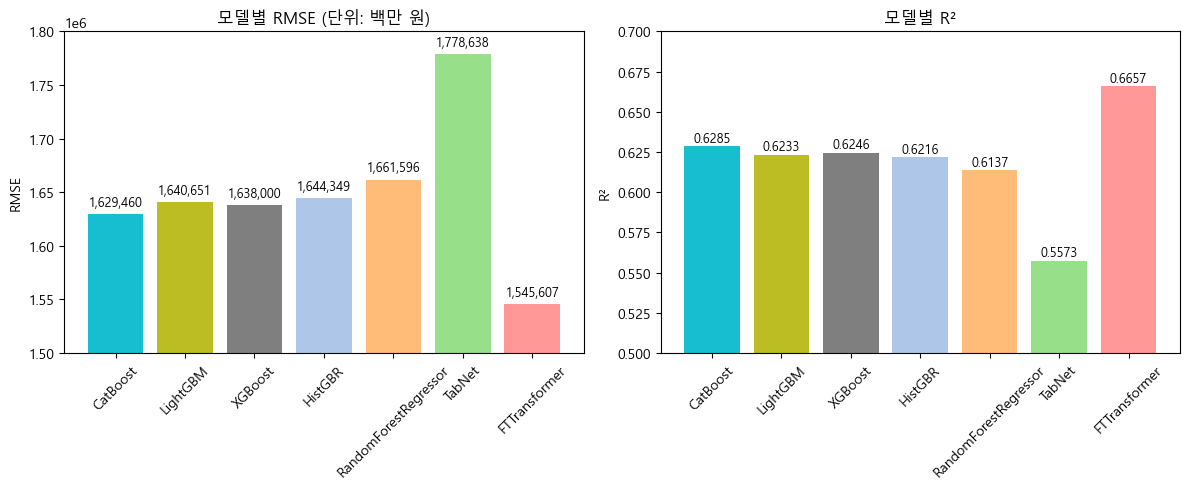

In [8]:
# 색상 (7개 모델)

colors = ['#17becf', '#bcbd22', '#7f7f7f', '#aec7e8', '#ffbb78', '#98df8a', '#ff9896']

# 시각화
plt.figure(figsize=(12, 5))

# ✅ RMSE 그래프
plt.subplot(1, 2, 1)
bars_rmse = plt.bar(df_results["모델명"], df_results["RMSE"], color=colors)
plt.title("모델별 RMSE (단위: 백만 원)")
plt.ylabel("RMSE")
plt.xticks(rotation=45)
plt.ylim(1500000, 1800000)  # y축 범위 설정

# RMSE 값 표시 (실제 값, 콤마 포함)
for bar in bars_rmse:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 5000, f"{yval:,.0f}", 
             ha='center', va='bottom', fontsize=9)

# ✅ R² 그래프
plt.subplot(1, 2, 2)
bars_r2 = plt.bar(df_results["모델명"], df_results["R²"], color=colors)
plt.title("모델별 R²")
plt.ylabel("R²")
plt.xticks(rotation=45)
plt.ylim(0.5, 0.7)  # R² 범위 설정 (차이 강조)

# R² 값 표시
for bar in bars_r2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.001, f"{yval:.4f}", 
             ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


### Adversarial Attack

일반 데이터로 학습, 훈련 데이터에 적대적 공격 적용한 코드

In [48]:
import numpy as np
from copy import deepcopy
from collections import defaultdict
from sklearn.metrics import mean_squared_error, r2_score

# 1. 카테고리 그룹 인덱스 생성 함수
def get_onehot_category_indices(columns):
    category_groups = defaultdict(list)
    for idx, col in enumerate(columns):
        if "_" in col:
            base = col.split("_")[0]
            category_groups[base].append(idx)
    return list(category_groups.values())

# 2. 카테고리 스위칭 공격 함수
def category_switch_attack(X, category_indices, num_switches=1, random_state=42):
    np.random.seed(random_state)
    X_adv = deepcopy(X)

    for i in range(X.shape[0]):
        switch_groups = np.random.choice(len(category_indices), size=num_switches, replace=False)
        for group_idx in switch_groups:
            indices = category_indices[group_idx]

            # ✅ DataFrame 대응: .iloc 사용
            current_onehot = X_adv.iloc[i, indices] if isinstance(X, pd.DataFrame) else X_adv[i, indices]

            if current_onehot.sum() == 1:
                current_pos = np.argmax(current_onehot)
                possible = list(set(range(len(indices))) - {current_pos})
                if possible:
                    new_pos = np.random.choice(possible)

                    # ✅ 원핫 스위칭 적용
                    if isinstance(X, pd.DataFrame):
                        for idx in indices:
                            X_adv.iat[i, idx] = 0
                        X_adv.iat[i, indices[new_pos]] = 1
                    else:
                        X_adv[i, indices] = 0
                        X_adv[i, indices[new_pos]] = 1

    return X_adv


# 3. 전체 모델 평가 함수
def evaluate_models_with_attack(models, X_test, y_test, columns, num_switches=1):
    category_indices = get_onehot_category_indices(columns)
    X_test_adv = category_switch_attack(X_test, category_indices, num_switches=num_switches)

    results = []

    for name, model in models.items():
        # ✅ TabNet은 넘파이 배열 입력 필요
        if "TabNet" in str(type(model)):
            y_pred = model.predict(X_test.values)
            y_pred_adv = model.predict(X_test_adv.values)
        else:
            y_pred = model.predict(X_test)
            y_pred_adv = model.predict(X_test_adv)

        r2 = r2_score(y_test, y_pred)
        r2_adv = r2_score(y_test, y_pred_adv)

        results.append({
            "모델명": name,
            "원본_R2": r2,
            "공격_R2": r2_adv
        })

    return results

In [54]:
# X_test가 DataFrame일 경우
columns = X_test.columns.tolist()

# X_test가 numpy array일 경우
# columns = X_df.columns.tolist()  # X_df는 X_test의 원본 DataFrame

all_results = []

for num in [1, 2, 3]:
    results = evaluate_models_with_attack(models, X_test, y_test, columns, num_switches=num)
    for res in results:
        res["스위칭_개수"] = num
        all_results.append(res)

results_df = pd.DataFrame(all_results)
results_df = results_df.sort_values(["모델명", "스위칭_개수"]).reset_index(drop=True)
print(results_df)


                      모델명     원본_R2     공격_R2  스위칭_개수
0                CatBoost  0.628458  0.542889       1
1                CatBoost  0.628458  0.469434       2
2                CatBoost  0.628458  0.391596       3
3                 HistGBR  0.621637  0.538277       1
4                 HistGBR  0.621637  0.466176       2
5                 HistGBR  0.621637  0.383912       3
6                LightGBM  0.623337  0.536614       1
7                LightGBM  0.623337  0.466576       2
8                LightGBM  0.623337  0.386120       3
9   RandomForestRegressor  0.613658  0.519564       1
10  RandomForestRegressor  0.613658  0.441308       2
11  RandomForestRegressor  0.613658  0.357138       3
12                 TabNet  0.557314  0.461842       1
13                 TabNet  0.557314  0.376157       2
14                 TabNet  0.557314  0.284939       3
15                XGBoost  0.624197  0.539952       1
16                XGBoost  0.624197  0.458767       2
17                XGBoost  0

In [ ]:
from rtdl import FTTransformer
from torch.serialization import safe_globals
import pickle

# ✅ 1. 데이터 로드
with open("./split_data/VIF_split_data_fn_transformer.pkl", "rb") as f:
    X_train_tensor, X_valid_tensor, X_test_tensor, y_train_tensor, y_valid_tensor, y_test_tensor = pickle.load(f)

# ✅ 2. FTTransformer 모델 로드
with safe_globals([FTTransformer]):
    ft_model = torch.load("./model/VIF_fttransformer_trained.pt", weights_only=False, map_location=torch.device("cpu"))
ft_model.eval()

In [53]:
import torch
from copy import deepcopy
from sklearn.metrics import r2_score
import numpy as np
import pandas as pd

# ✅ 1. 범주형 변수 자동 추정 (value_counts 기반)
X_train_df = pd.DataFrame(X_train_tensor.numpy())

categorical_indices = []
category_value_map = {}

for idx in X_train_df.columns:
    unique_values = X_train_df[idx].value_counts().index.tolist()
    if X_train_df[idx].dtype in ['int32', 'int64', 'float32', 'float64'] and len(unique_values) <= 20:
        categorical_indices.append(idx)
        category_value_map[idx] = unique_values

# ✅ 2. 범주형만 분리 함수 (연속형은 무시)
def extract_categorical_only(X_tensor, categorical_indices):
    return X_tensor[:, categorical_indices].long()

# ✅ 3. 적대적 공격 함수
def category_switch_attack_tensor(X_tensor, categorical_indices, category_value_map, num_switches=1, random_state=42):
    np.random.seed(random_state)
    X_np = X_tensor.numpy()
    X_adv = deepcopy(X_np)

    for i in range(X_adv.shape[0]):
        selected = np.random.choice(categorical_indices, size=min(num_switches, len(categorical_indices)), replace=False)
        for col in selected:
            current_val = X_adv[i, col]
            possible = list(set(category_value_map[col]) - {current_val})
            if possible:
                X_adv[i, col] = np.random.choice(possible)

    return torch.tensor(X_adv, dtype=X_tensor.dtype)

# ✅ 4. 배치 예측 함수
def predict_in_batches(model, x_cat_tensor, batch_size=512):
    model.eval()
    preds = []
    with torch.no_grad():
        for i in range(0, len(x_cat_tensor), batch_size):
            batch_cat = x_cat_tensor[i:i+batch_size]
            batch_out = model(None, batch_cat).squeeze().cpu().numpy()
            preds.append(batch_out)
    return np.concatenate(preds)

# ✅ 5. 공격 전 성능 평가
y_true = y_test_tensor.numpy()
x_cat_test = extract_categorical_only(X_test_tensor, categorical_indices)
y_pred_original = predict_in_batches(ft_model, x_cat_test)
r2_original = r2_score(y_true, y_pred_original)

# ✅ 6. 공격 반복 (num_switches = 1, 2, 3)
all_results = []

for num in [1, 2, 3]:
    X_test_adv_tensor = category_switch_attack_tensor(
        X_test_tensor,
        categorical_indices,
        category_value_map,
        num_switches=num
    )
    x_cat_adv = extract_categorical_only(X_test_adv_tensor, categorical_indices)
    y_pred_adv = predict_in_batches(ft_model, x_cat_adv)
    r2_adv = r2_score(y_true, y_pred_adv)

    all_results.append({
        "모델명": "FTTransformer",
        "스위칭_개수": num,
        "원본_R2": r2_original,
        "공격_R2": r2_adv
    })

# ✅ 7. 결과 출력
results_df = pd.DataFrame(all_results)
print(results_df)


             모델명  스위칭_개수     원본_R2     공격_R2
0  FTTransformer       1  0.665714  0.503461
1  FTTransformer       2  0.665714  0.374239
2  FTTransformer       3  0.665714  0.267626


In [55]:
# FTTransformer 결과 (이미 존재하는 DataFrame이라고 가정)
ft_result_df = pd.DataFrame([
    {"모델명": "FTTransformer", "스위칭_개수": 1, "원본_R2": 0.665714, "공격_R2": 0.503461},
    {"모델명": "FTTransformer", "스위칭_개수": 2, "원본_R2": 0.665714, "공격_R2": 0.374239},
    {"모델명": "FTTransformer", "스위칭_개수": 3, "원본_R2": 0.665714, "공격_R2": 0.267626},
])

# 기존 results_df와 합치기
results_df = pd.concat([results_df, ft_result_df], ignore_index=True)

# 확인
print(results_df)


                      모델명     원본_R2     공격_R2  스위칭_개수
0                CatBoost  0.628458  0.542889       1
1                CatBoost  0.628458  0.469434       2
2                CatBoost  0.628458  0.391596       3
3                 HistGBR  0.621637  0.538277       1
4                 HistGBR  0.621637  0.466176       2
5                 HistGBR  0.621637  0.383912       3
6                LightGBM  0.623337  0.536614       1
7                LightGBM  0.623337  0.466576       2
8                LightGBM  0.623337  0.386120       3
9   RandomForestRegressor  0.613658  0.519564       1
10  RandomForestRegressor  0.613658  0.441308       2
11  RandomForestRegressor  0.613658  0.357138       3
12                 TabNet  0.557314  0.461842       1
13                 TabNet  0.557314  0.376157       2
14                 TabNet  0.557314  0.284939       3
15                XGBoost  0.624197  0.539952       1
16                XGBoost  0.624197  0.458767       2
17                XGBoost  0

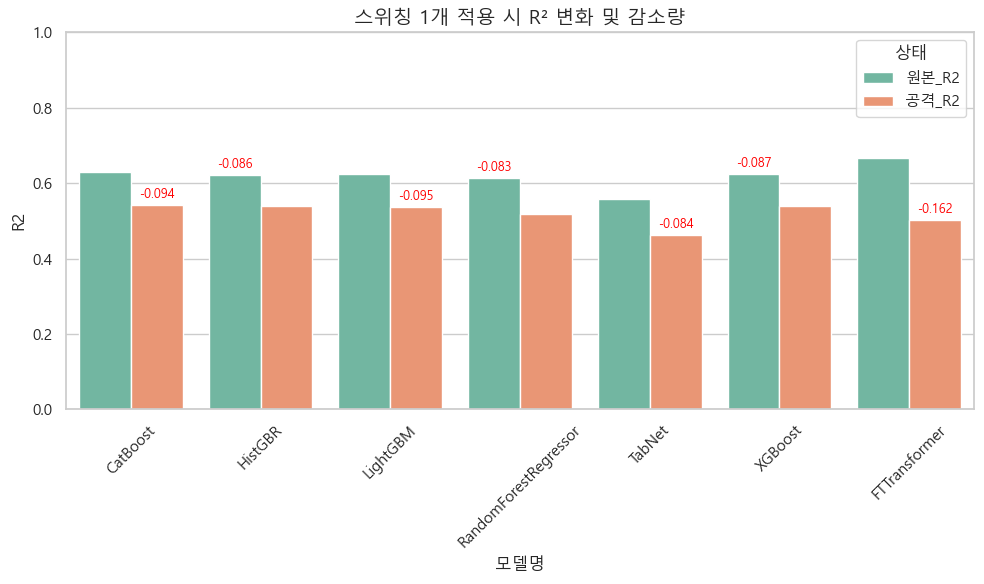

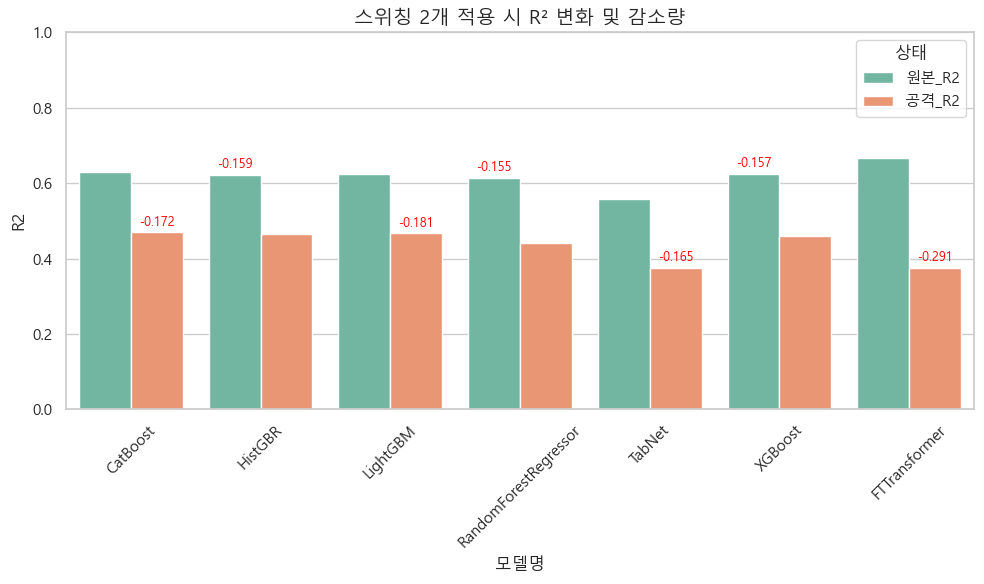

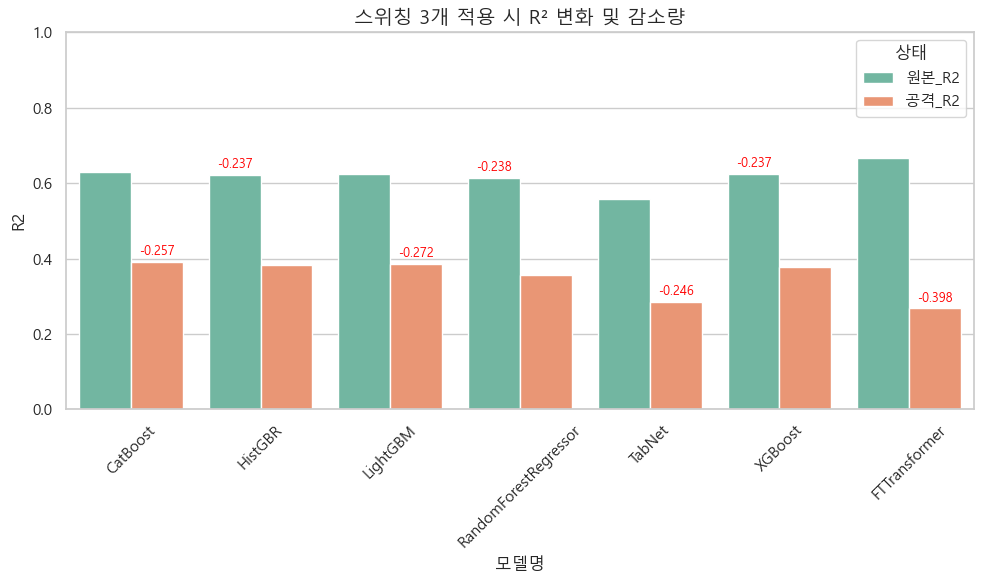

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", font="Malgun Gothic")

for k in [1, 2, 3]:
    subset = results_df[results_df["스위칭_개수"] == k].copy()
    subset["R2_감소량"] = subset["원본_R2"] - subset["공격_R2"]

    melted = subset.melt(id_vars=["모델명", "R2_감소량"], 
                         value_vars=["원본_R2", "공격_R2"],
                         var_name="상태", value_name="R2")

    plt.figure(figsize=(10, 6))
    ax = sns.barplot(data=melted, x="모델명", y="R2", hue="상태", palette="Set2")

    # ⚠️ 순서를 보장하기 위해 모델명 리스트 확보
    model_list = subset["모델명"].tolist()

    # ✅ 막대 순서대로 text 표시 (공격_R2에만)
    patch_idx = 0
    for i, bar in enumerate(ax.patches):
        # bar는 모델 하나당 2개씩 (원본, 공격) 있으므로 index 짝수는 원본, 홀수는 공격
        if i % 2 == 1:  # 공격_R2 막대
            model_idx = i // 2
            if model_idx < len(model_list):
                model_name = model_list[model_idx]
                drop = subset[subset["모델명"] == model_name]["R2_감소량"].values[0]
                ax.text(bar.get_x() + bar.get_width() / 2,
                        bar.get_height() + 0.01,
                        f"-{drop:.3f}",
                        ha="center", va="bottom", fontsize=9, color="red")

    plt.title(f"스위칭 {k}개 적용 시 R² 변화 및 감소량", fontsize=14)
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


### 6.  Odd ratio CI p-value

In [ ]:
import pickle
with open("./split_data/VIF_split_data_3way.pkl", "rb") as f:
    X_train, X_valid, X_test, y_train, y_valid, y_test = pickle.load(f)

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# 1. 작업용 데이터 생성
X_glm = X_train.copy()
y_glm = y_train.copy()

# 2. 절편 추가 
X_glm['intercept'] = 1.0

# 3. 분석 대상 변수 목록
variables = X_glm.columns.drop('intercept')

# 4. 결과 저장용 딕셔너리
univariate_results = {}

# 5. 단변량 GLM 분석 반복 수행
for var in variables:
    X_single = X_glm[['intercept', var]]  # intercept + 현재 변수만 사용
    model = sm.GLM(y_glm, X_single, family=sm.families.Gaussian()).fit()
    # statsmodels의 일반 회귀 GLM 모델 사용 
    univariate_results[var] = {
        'coef': model.params[var],
        'p-value': model.pvalues[var],
        '95% CI': model.conf_int().loc[var]
    }

# 6. 결과 정리
results_list = []

for var, stats in univariate_results.items():
    odds_ratio = np.exp(stats['coef'])  # OR = exp(coef)
    lower_ci, upper_ci = np.exp(stats['95% CI'])  # CI도 OR 기준으로 변환

    results_list.append({
        'Variable': var,
        'Odds Ratio': odds_ratio,
        'p-value': stats['p-value'],
        '95% CI Lower': lower_ci,
        '95% CI Upper': upper_ci
    })

# 7. 결과 DataFrame 생성 및 정리
results_df = pd.DataFrame(results_list)
column_order = ['Variable', 'Odds Ratio', 'p-value', '95% CI Lower', '95% CI Upper']
results_df = results_df[column_order]

# 8. 결과 출력
results_df


,Variable,Odds Ratio,p-value,95% CI Lower,95% CI Upper
0,면적,0.866470,1.056183e-123,0.856240,0.876821
1,지번구분_2,0.994392,0.000000e+00,0.994204,0.994579
2,지번구분_기타,1.001726,1.210968e-04,1.000846,1.002607
3,시도명_경상남도,0.995486,0.000000e+00,0.995324,0.995648
4,시도명_경상북도,0.994918,0.000000e+00,0.994762,0.995074
5,시도명_광주광역시,0.999175,8.082552e-05,0.998766,0.999585
6,시도명_대구광역시,1.002805,3.324823e-60,1.002469,1.003142
7,시도명_대전광역시,1.000493,3.598884e-02,1.000032,1.000953
8,시도명_부산광역시,1.006966,0.000000e+00,1.006676,1.007256
9,시도명_서울특별시,1.039487,0.000000e+00,1.039296,1.039679


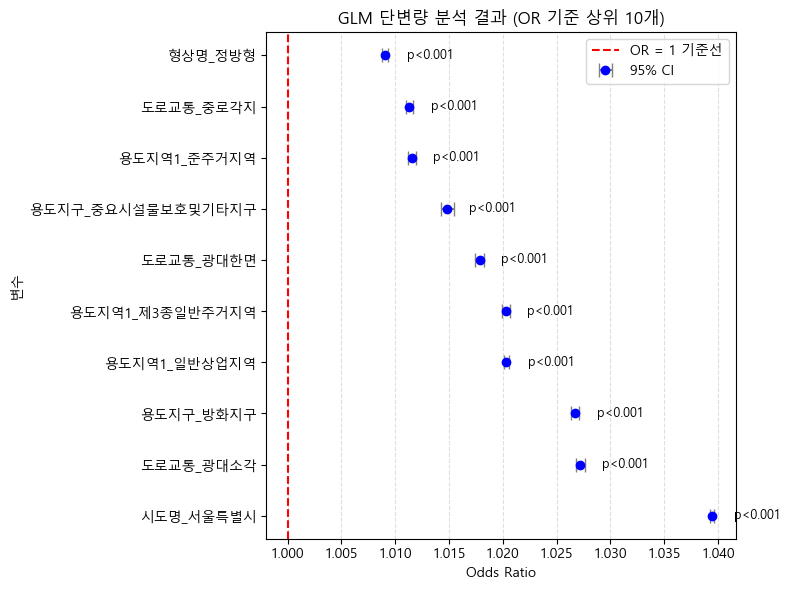

In [ ]:
import matplotlib.pyplot as plt
# 한글 폰트 설정 (Windows 기본 폰트)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지
# OR 기준 상위 10개
top10 = results_df.sort_values(by="Odds Ratio", ascending=False).head(10).reset_index(drop=True)

plt.figure(figsize=(8, 6))
plt.errorbar(
    x=top10["Odds Ratio"],
    y=top10["Variable"],
    xerr=[top10["Odds Ratio"] - top10["95% CI Lower"], top10["95% CI Upper"] - top10["Odds Ratio"]],
    fmt='o', color='blue', ecolor='gray', capsize=5, label="95% CI"
)

# 기준선
plt.axvline(x=1, color='red', linestyle='--', label='OR = 1 기준선')

# p-value 라벨 표시 (보기 좋게 고정 소수점 표기)
for i, row in top10.iterrows():
    if row['p-value'] < 0.001:
        p_text = "p<0.001"
    else:
        p_text = f"p={row['p-value']:.3f}"  # 소수점 3자리까지 고정
    plt.text(row["Odds Ratio"] + 0.002, i, p_text, va='center', fontsize=9, color='black')

# 레이아웃
plt.title("GLM 단변량 분석 결과 (OR 기준 상위 10개)")
plt.xlabel("Odds Ratio")
plt.ylabel("변수")
plt.grid(True, axis='x', linestyle='--', alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()



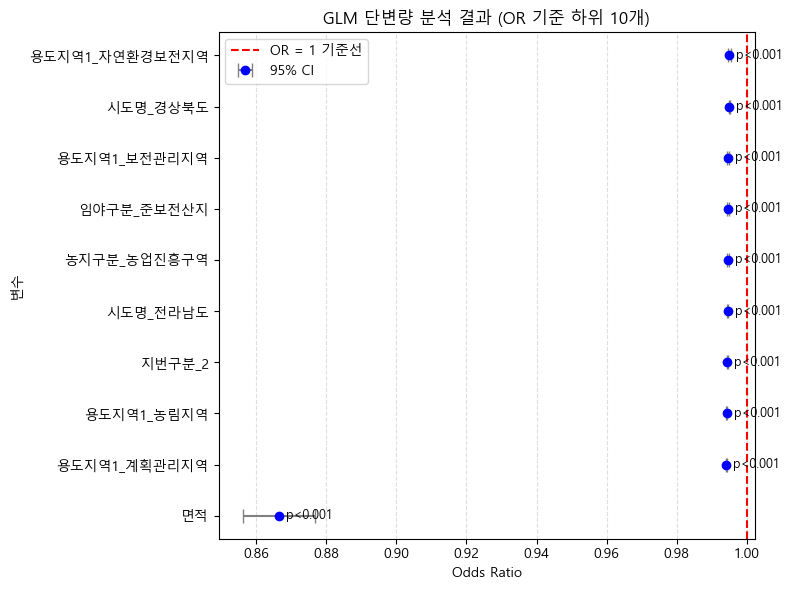

In [ ]:
import matplotlib.pyplot as plt
# 한글 폰트 설정 (Windows 기본 폰트)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지
# OR 기준 하위 10개
top10 = results_df.sort_values(by="Odds Ratio", ascending=True).head(10).reset_index(drop=True)

plt.figure(figsize=(8, 6))
plt.errorbar(
    x=top10["Odds Ratio"],
    y=top10["Variable"],
    xerr=[top10["Odds Ratio"] - top10["95% CI Lower"], top10["95% CI Upper"] - top10["Odds Ratio"]],
    fmt='o', color='blue', ecolor='gray', capsize=5, label="95% CI"
)

# 기준선
plt.axvline(x=1, color='red', linestyle='--', label='OR = 1 기준선')

# p-value 라벨 표시 (보기 좋게 고정 소수점 표기)
for i, row in top10.iterrows():
    if row['p-value'] < 0.001:
        p_text = "p<0.001"
    else:
        p_text = f"p={row['p-value']:.3f}"  # 소수점 3자리까지 고정
    plt.text(row["Odds Ratio"] + 0.002, i, p_text, va='center', fontsize=9, color='black')

# 레이아웃
plt.title("GLM 단변량 분석 결과 (OR 기준 하위 10개)")
plt.xlabel("Odds Ratio")
plt.ylabel("변수")
plt.grid(True, axis='x', linestyle='--', alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

### 10. Residual plot / QQ plot / Actual value and Prediction value visualization

In [ ]:
import torch
from rtdl import FTTransformer
from torch.serialization import safe_globals
import pickle

# ✅ 디바이스 설정 (GPU 우선)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"사용 중인 디바이스: {device}")

# ✅ 1. 모델 불러오기 (GPU 로드)
with safe_globals([FTTransformer]):
    model = torch.load("./model/VIF_fttransformer_trained.pt", weights_only=False, map_location=device)
model.eval()

# ✅ 2. 학습 데이터 불러오기
with open("./model/VIF_split_data_fn_transformer.pkl", "rb") as f:
    X_train_tensor, X_valid_tensor, X_test_tensor, y_train_tensor, y_valid_tensor, y_test_tensor = pickle.load(f)

# ✅ 3. GPU로 데이터 이동
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

# ✅ 4. 예측
with torch.no_grad():
    x_cat = X_test_tensor.long()  # FT-Transformer는 범주형 입력 전용
    y_pred_tensor = model(None, x_cat).squeeze()

# ✅ 5. numpy 변환
y_pred = y_pred_tensor.cpu().numpy()
y_true = y_test_tensor.squeeze().cpu().numpy()

# ✅ 6. 역정규화
y_min = 216.0
y_max = 165300000.0
y_pred_inverse = y_pred * (y_max - y_min) + y_min
y_true_inverse = y_true * (y_max - y_min) + y_min

# ✅ 7. 잔차 계산
residuals = y_true_inverse - y_pred_inverse

print("✅ 예측 및 잔차 계산 완료")


사용 중인 디바이스: cuda
✅ 예측 및 잔차 계산 완료


In [4]:
with open("residuals.pkl", "wb") as f:
    pickle.dump((residuals, y_pred_inverse), f)

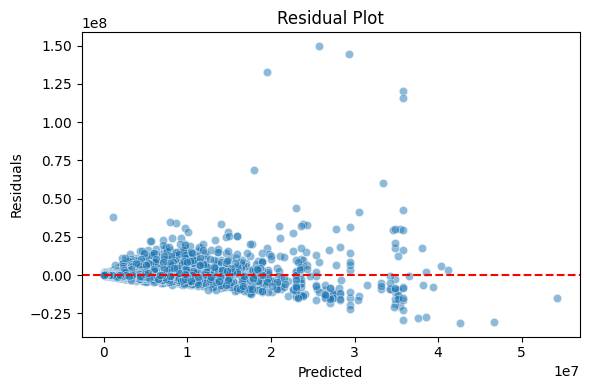

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# 1. Residual Plot
plt.figure(figsize=(6, 4))
sns.scatterplot(x=y_pred_inverse, y=residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.tight_layout()
plt.show()

<Figure size 600x400 with 0 Axes>

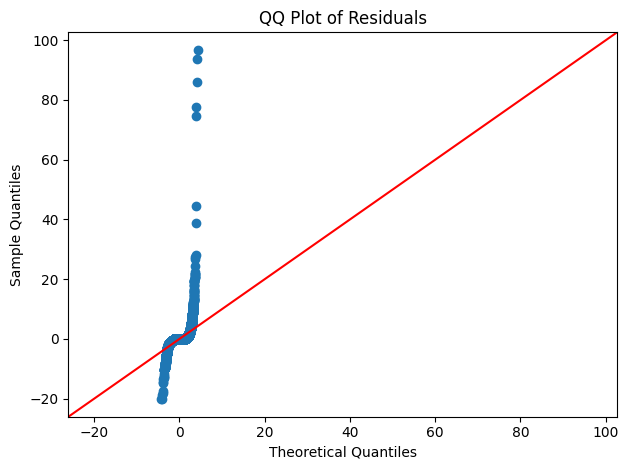

In [ ]:
import statsmodels.api as sm
# 2. QQ Plot
plt.figure(figsize=(6, 4))
sm.qqplot(residuals, line='45', fit=True)
plt.title("QQ Plot of Residuals")
plt.tight_layout()
plt.show()

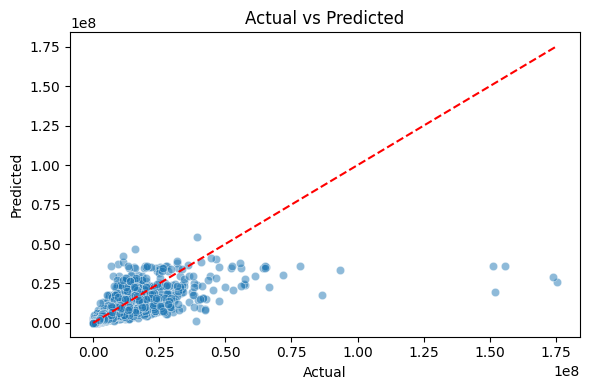

In [ ]:
# 3. Actual vs Predicted
plt.figure(figsize=(6, 4))
sns.scatterplot(x=y_true_inverse, y=y_pred_inverse, alpha=0.5)
plt.plot([y_true_inverse.min(), y_true_inverse.max()],
         [y_true_inverse.min(), y_true_inverse.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted")
plt.tight_layout()
plt.show()